<a href="https://colab.research.google.com/github/mounika2403/Classification-of-fabric-patterns-using-dl/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from numpy import random
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/patterns.zip

Archive:  /content/drive/MyDrive/patterns.zip
replace data_pattern/animal/3280.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data_pattern/animal/3281.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: nn
replace data_pattern/animal/3282.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
directory = '/content/data_pattern'
labels = os.listdir(directory)

In [ ]:
def read_data(folder):
    label, paths = [], []
    for l in labels:
        path = f"{folder}/{l}/"
        folder_data = os.listdir(path)
        for image_path in folder_data:
            label.append(l)
            paths.append(os.path.join(directory, l, image_path))
    return label, paths


In [ ]:
all_labels, all_paths = read_data(directory)

In [ ]:
df = pd.DataFrame({
    'path': all_paths,
    'label': all_labels
})
df

,path,label
0,/content/data_pattern/ikat/3091.jpg,ikat
1,/content/data_pattern/ikat/3077.jpg,ikat
2,/content/data_pattern/ikat/3206.jpg,ikat
3,/content/data_pattern/ikat/3111.jpg,ikat
4,/content/data_pattern/ikat/3028.jpg,ikat
...,...,...
4225,/content/data_pattern/geometry/3819.jpg,geometry
4226,/content/data_pattern/geometry/3949.jpg,geometry
4227,/content/data_pattern/geometry/3659.jpg,geometry
4228,/content/data_pattern/geometry/3855.jpg,geometry


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, dummy_df = train_test_split(
    df,
    train_size=0.8,
    random_state=123,
    shuffle=True,
    stratify=df['label']
)

In [ ]:
valid_df, test_df = train_test_split(
    dummy_df,
    train_size=0.5,
    random_state=123,
    shuffle=True,
    stratify=dummy_df['label']
)

In [ ]:
print("Train dataset :", len(train_df),
      "Test dataset :", len(test_df),
      "Validation dataset :", len(valid_df))

Train dataset : 3384 Test dataset : 423 Validation dataset : 423


In [ ]:
train_balance = train_df['label'].value_counts()
print('Train dataset value count: \n', train_balance)

Train dataset value count: 
 label
stripes      400
polka dot    398
plain        398
tribal       397
floral       396
squares      351
ikat         284
animal       281
geometry     271
cartoon      208
Name: count, dtype: int64


In [ ]:
directory='/content/data_pattern'

In [ ]:
labels=os.listdir(directory)
labels

['ikat',
 'plain',
 'floral',
 'animal',
 'cartoon',
 'tribal',
 'squares',
 'stripes',
 'polka dot',
 'geometry']

In [ ]:
import cv2
import numpy as np

In [ ]:
def apply_transform(image):
  angle=np.random.uniform(-40, 40)
  rows,cols=image.shape[:2]
  M=cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
  image = cv2.warpAffine(image, M, (cols, rows))

  if np.random.rand() < 0.5:  #horizontal flip
    image = cv2.flip(image, 1)

  if np.random.rand() < 0.5:   #vertical flip
    image = cv2.flip(image, 0)

  alpha = 1.0 + np.random.uniform(-0.2, 0.2)   # Brightness (scale)
  beta = 0.0 + np.random.uniform(-0.2, 0.2)    # Contrast (shift)
  image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

  gamma = np.random.uniform(0.8, 1.2)      #gamma correction
  image = np.clip((image / 255.0) ** gamma, 0, 1) * 255.0

  return image

In [ ]:
def apply_augmentation(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    augmented_image = apply_transform(image=image)
    return augmented_image, label

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
!pip install keras

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
gen = ImageDataGenerator(rescale=1./255,          # Normalize pixel values
    rotation_range=20,       # Rotate images by up to 20 degrees
    width_shift_range=0.2,   # Shift images horizontally
    height_shift_range=0.2,  # Shift images vertically
    shear_range=0.2,         # Apply shear transformation
    zoom_range=0.2,          # Zoom in on images
    horizontal_flip=True,    # Flip images horizontally
    fill_mode='nearest'      )

In [ ]:
train_gen = gen.flow_from_dataframe(train_df, x_col='path', y_col='label',
                                    target_size=(255, 255), seed=123,
                                    class_mode='categorical', color_mode='rgb',
                                    shuffle=True, batch_size=32)

Found 3384 validated image filenames belonging to 10 classes.


In [ ]:
valid_gen = gen.flow_from_dataframe(valid_df, x_col='path', y_col='label',
                                    target_size=(255, 255), seed=123,
                                    class_mode='categorical', color_mode='rgb',
                                    shuffle=False, batch_size=32)

Found 423 validated image filenames belonging to 10 classes.


In [ ]:
test_gen = gen.flow_from_dataframe(test_df, x_col='path', y_col='label',
                                   target_size=(255, 255), seed=123,
                                   class_mode='categorical', color_mode='rgb',
                                   shuffle=False, batch_size=32)

Found 423 validated image filenames belonging to 10 classes.


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras import regularizers
from keras.optimizers import Adam, Adamax
import tensorflow as tf

In [ ]:
model = Sequential()
model.add(Convolution2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(255, 255, 3)))
model.add(MaxPooling2D(strides=2, pool_size=2, padding='valid'))
model.add(Convolution2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(strides=2, pool_size=2, padding='valid'))
model.add(Dropout(0.5))
#model.add(Convolution2D(filters=32, kernel_size=2, padding='same', activation='relu'))
#model.add(MaxPooling2D(strides=2, pool_size=2, padding='valid'))
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 255, 255, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 127, 127, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 127008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │    16,257,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,263,337 (62.04 MB)

 Trainable params: 16,263,337 (62.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
"""model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_cnn.h5",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)"""

'model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(\n    filepath="model_cnn.h5",\n    monitor=\'val_accuracy\',\n    mode=\'max\',\n    save_best_only=True,\n    verbose=1)'

In [ ]:
"""model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.add(Dense(10, activation='softmax'))  # instead of Dense(9, ...)"""

"model.compile(loss='categorical_crossentropy',\n              optimizer='adam',\n              metrics=['accuracy'])\nmodel.add(Dense(10, activation='softmax'))  # instead of Dense(9, ...)"

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.add(Dense(10, activation='softmax'))  # instead of Dense(9, ...)

In [ ]:
# Example (in your training script, NOT app.py)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks
model_checkpoint_callback = ModelCheckpoint(
    filepath="model_cnn.h5",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10, # Stop if validation accuracy doesn't improve for 10 epochs
    restore_best_weights=True,
    verbose=1
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Reduce learning rate by 0.2
    patience=5, # If val_loss doesn't improve for 5 epochs
    min_lr=0.000001, # Minimum learning rate
    verbose=1
)


In [ ]:
history_cnn = model.fit(
    x=train_gen,
    epochs=40, # Try more epochs, EarlyStopping will prevent overfitting
    verbose=1,
    validation_data=valid_gen,
    validation_steps=None, # Keras will calculate steps from generator if None
    shuffle=True,
    callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)

Epoch 1/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.1781 - loss: 2.2499
Epoch 1: val_accuracy improved from 0.18913 to 0.21986, saving model to model_cnn.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 61s 576ms/step - accuracy: 0.1782 - loss: 2.2499 - val_accuracy: 0.2199 - val_loss: 2.2103 - learning_rate: 0.0010
Epoch 2/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.1551 - loss: 2.2611
Epoch 2: val_accuracy did not improve from 0.21986
106/106 ━━━━━━━━━━━━━━━━━━━━ 61s 580ms/step - accuracy: 0.1552 - loss: 2.2611 - val_accuracy: 0.1962 - val_loss: 2.2261 - learning_rate: 0.0010
Epoch 3/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.1392 - loss: 2.2815
Epoch 3: val_accuracy did not improve from 0.21986
106/106 ━━━━━━━━━━━━━━━━━━━━ 60s 565ms/step - accuracy: 0.1390 - loss: 2.2816 - val_accuracy: 0.1182 - val_loss: 2.2922 - learning_rate: 0.0010
Epoch 4/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.1141 - loss: 2.2886
Epoch 4: val_accuracy did not improve from 0.21986
106/106 ━━━━━━━━━━━━━━━━━━━━ 60s 567ms/step - accuracy: 0.1141 - loss: 2.2886 - val_accuracy: 0.1182 - val_loss: 2.2860 - learning_rate: 0.0010
Epoch 5

In [ ]:
"""history_cnn = model.fit(x=train_gen, epochs=25, verbose=1, validation_data=valid_gen,
                        validation_steps=None, shuffle=True, callbacks=[model_checkpoint_callback])"""

'history_cnn = model.fit(x=train_gen, epochs=25, verbose=1, validation_data=valid_gen,\n                        validation_steps=None, shuffle=True, callbacks=[model_checkpoint_callback])'

In [ ]:
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(255,255,3))
print('Created ResNet50 model')

Created ResNet50 model


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
for layer in base_model.layers[173:]:
    layer.trainable = True

In [ ]:
x1 = base_model.output

# Global average pool to reduce number of features and Flatten the output
x2 = tf.keras.layers.GlobalAveragePooling2D()(x1)

In [ ]:
# adding extra layers
x3 = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer="he_uniform")(x2)
x4 = tf.keras.layers.Dropout(0.4)(x3)
x5 = tf.keras.layers.Dense(512, activation='relu', kernel_initializer="he_uniform")(x4)

In [ ]:
# Add output layer
prediction = tf.keras.layers.Dense(7, activation='softmax')(x5)

In [ ]:
final_model = tf.keras.models.Model(inputs=base_model.input,  # Pre-trained model input as input layer
                                    outputs=prediction)

In [ ]:
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_checkpoint_callback_rs = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_50.h5",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:
"""model.compile(loss='categorical_classentropy',
              optimizer='adam',
              metrics=['accuracy'])"""
model.compile(optimizer=Adam(learning_rate=0.0001), # Slightly lower learning rate for transfer learning
              loss='categorical_crossentropy',       # Corrected loss function
              metrics=['accuracy'])

In [ ]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

predictions = tf.keras.layers.Dense(10, activation='softmax')(x)
final_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_resnet=final_model.fit(train_gen,
                               epochs=10,
                               validation_data=valid_gen,callbacks=[model_checkpoint_callback_rs])

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.1245 - loss: 2.3818
Epoch 1: val_accuracy improved from -inf to 0.17730, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 84s 693ms/step - accuracy: 0.1248 - loss: 2.3811 - val_accuracy: 0.1773 - val_loss: 2.2325
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.1889 - loss: 2.2034
Epoch 2: val_accuracy improved from 0.17730 to 0.19858, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 69s 598ms/step - accuracy: 0.1890 - loss: 2.2035 - val_accuracy: 0.1986 - val_loss: 2.2276
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.2163 - loss: 2.1934
Epoch 3: val_accuracy improved from 0.19858 to 0.24113, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 65s 614ms/step - accuracy: 0.2163 - loss: 2.1932 - val_accuracy: 0.2411 - val_loss: 2.1442
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.2275 - loss: 2.1572
Epoch 4: val_accuracy improved from 0.24113 to 0.25296, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 81s 604ms/step - accuracy: 0.2275 - loss: 2.1572 - val_accuracy: 0.2530 - val_loss: 2.1433
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.2591 - loss: 2.1148
Epoch 5: val_accuracy improved from 0.25296 to 0.25532, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 64s 603ms/step - accuracy: 0.2590 - loss: 2.1149 - val_accuracy: 0.2553 - val_loss: 2.0960
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.2541 - loss: 2.1174
Epoch 6: val_accuracy improved from 0.25532 to 0.26005, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 67s 634ms/step - accuracy: 0.2542 - loss: 2.1174 - val_accuracy: 0.2600 - val_loss: 2.1000
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.2526 - loss: 2.0844
Epoch 7: val_accuracy did not improve from 0.26005
106/106 ━━━━━━━━━━━━━━━━━━━━ 66s 627ms/step - accuracy: 0.2525 - loss: 2.0845 - val_accuracy: 0.2388 - val_loss: 2.1172
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.2497 - loss: 2.0957
Epoch 8: val_accuracy did not improve from 0.26005
106/106 ━━━━━━━━━━━━━━━━━━━━ 63s 597ms/step - accuracy: 0.2498 - loss: 2.0957 - val_accuracy: 0.2364 - val_loss: 2.1338
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.2628 - loss: 2.0778
Epoch 9: val_accuracy did not improve from 0.26005
106/106 ━━━━━━━━━━━━━━━━━━━━ 85s 629ms/step - accuracy: 0.2628 - loss: 2.0778 - val_accuracy: 0.2459 - val_loss: 2.0735
Epoch 10/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.2646 - loss: 2.0879
Epoch 10: val_

106/106 ━━━━━━━━━━━━━━━━━━━━ 65s 616ms/step - accuracy: 0.2646 - loss: 2.0878 - val_accuracy: 0.2695 - val_loss: 2.0849


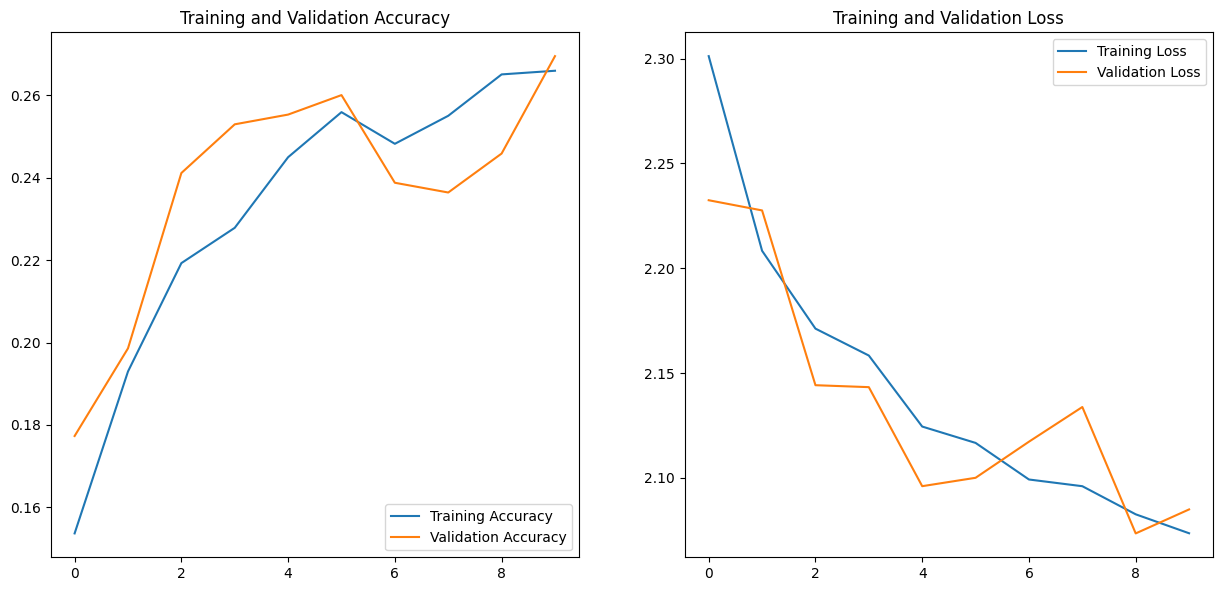

In [ ]:
import matplotlib.pyplot as plt

acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def predictor(model, test_gen):
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    preds = model.predict(test_gen, verbose=1)
    errors = 0
    pred_indices = []
    test_count = len(preds)
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        pred_indices.append(pred_index)
        true_index = test_gen.labels[i]
        if pred_index != true_index:
            errors += 1

    accuracy = (test_count - errors) * 100 / test_count
    ytrue = np.array(test_gen.labels, dtype='int')
    ypred = np.array(pred_indices, dtype='int')
    msg = f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:.2f}'
    print(msg)

    cm = confusion_matrix(ytrue, ypred)
    # plot the confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
    plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    clr = classification_report(ytrue, ypred, target_names=classes, digits=4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return


14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 787ms/step
There were 319 errors in 423 tests for an accuracy of 24.59


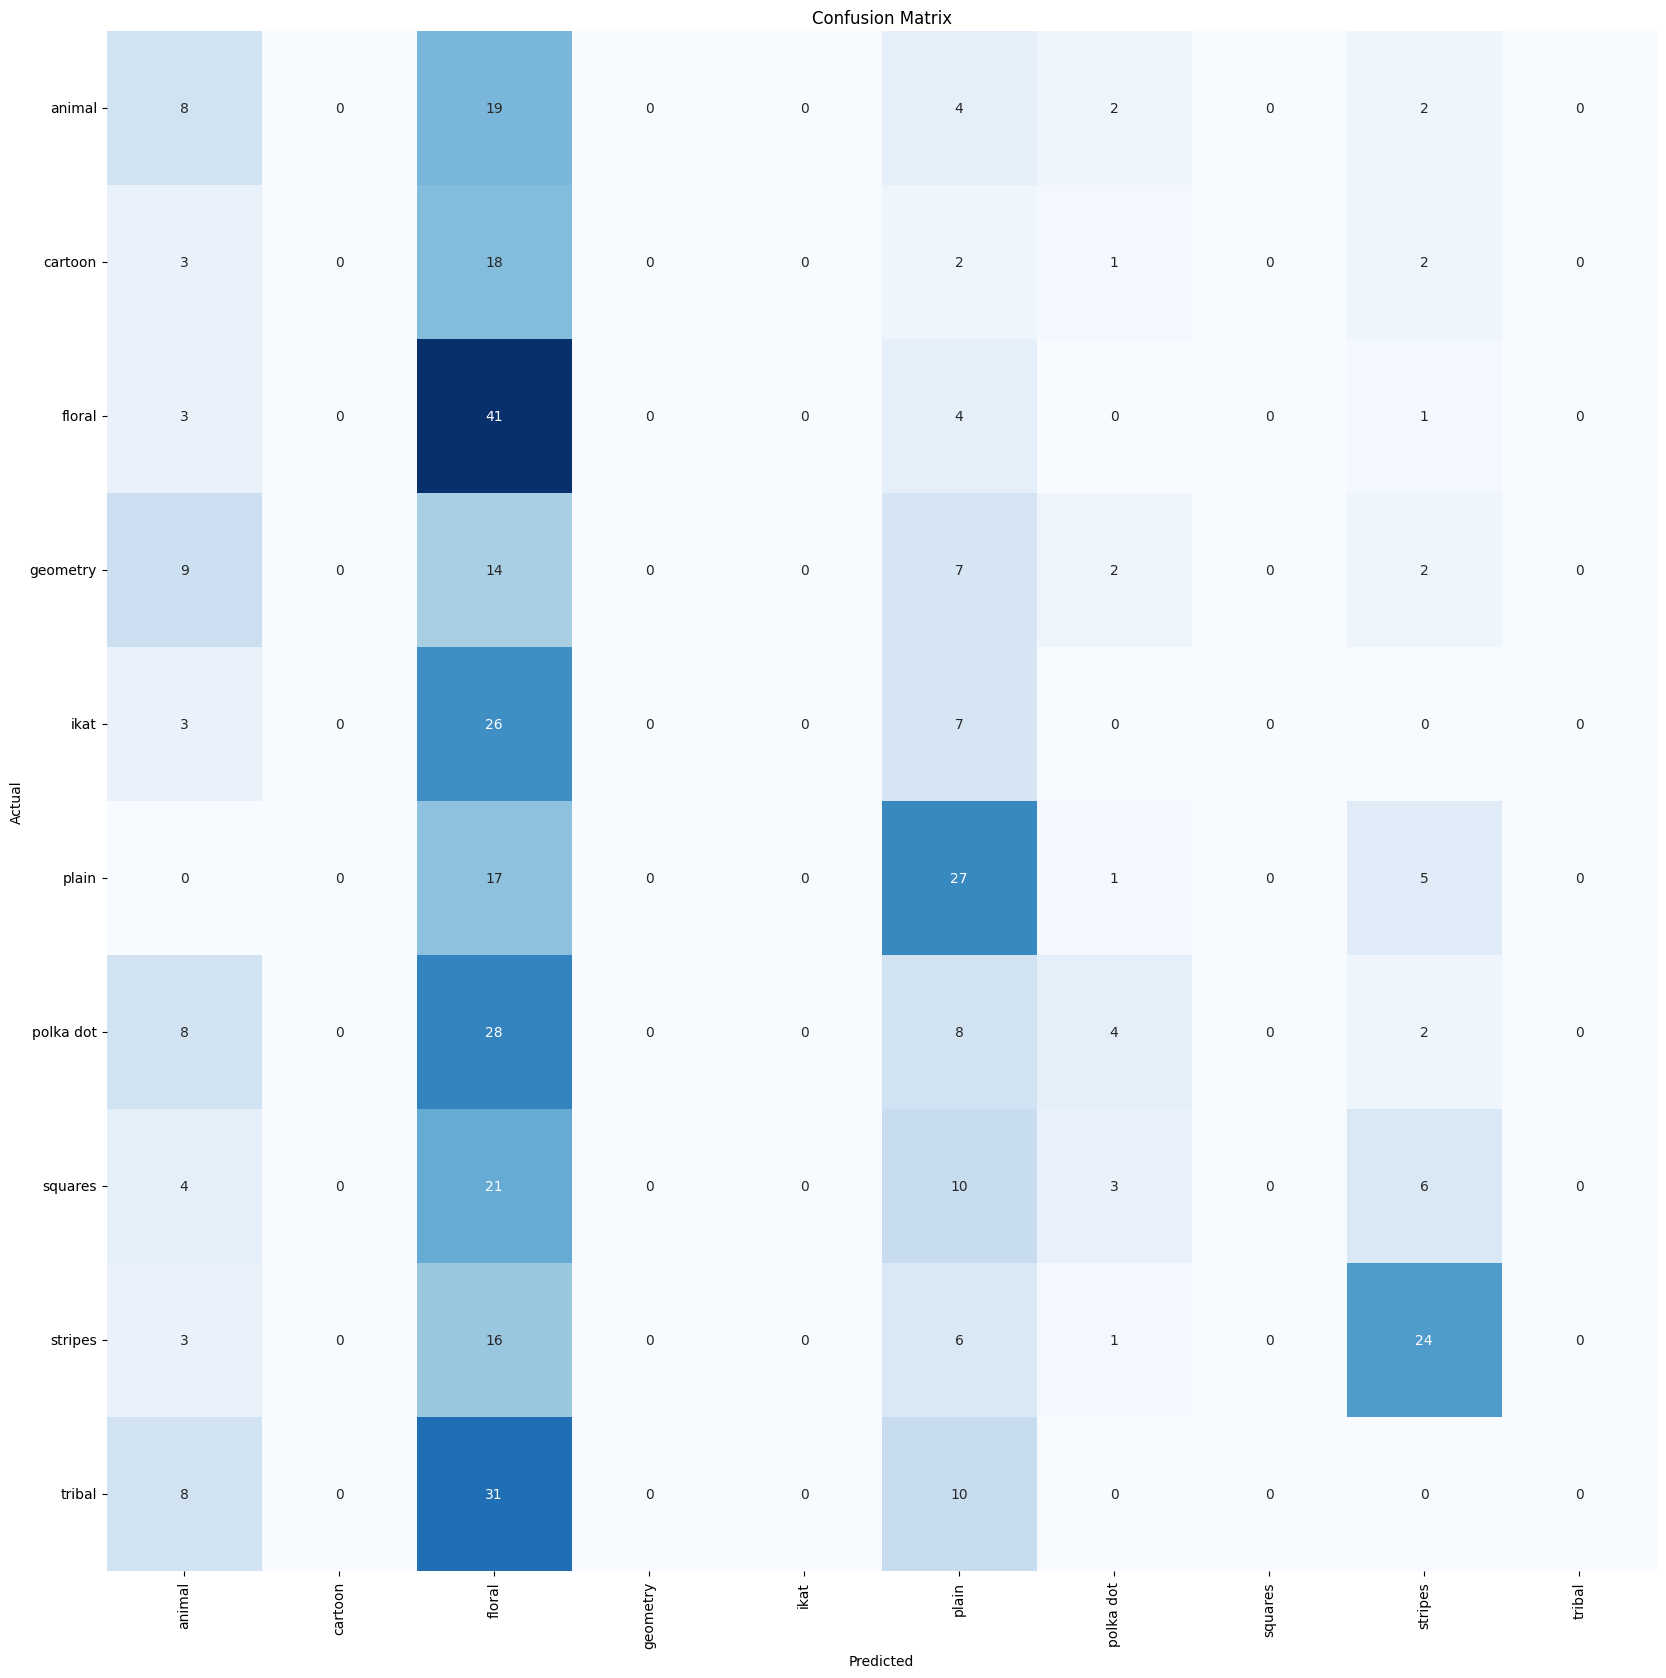

Classification Report:
----------------------
               precision    recall  f1-score   support

      animal     0.1633    0.2286    0.1905        35
     cartoon     0.0000    0.0000    0.0000        26
      floral     0.1775    0.8367    0.2929        49
    geometry     0.0000    0.0000    0.0000        34
        ikat     0.0000    0.0000    0.0000        36
       plain     0.3176    0.5400    0.4000        50
   polka dot     0.2857    0.0800    0.1250        50
     squares     0.0000    0.0000    0.0000        44
     stripes     0.5455    0.4800    0.5106        50
      tribal     0.0000    0.0000    0.0000        49

    accuracy                         0.2459       423
   macro avg     0.1490    0.2165    0.1519       423
weighted avg     0.1699    0.2459    0.1721       423



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
predictor(final_model,test_gen)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def get_model_prediction(image_path):
    img = load_img(image_path, target_size=(255, 255))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x, verbose=0)
    return labels[predictions.argmax()]

In [ ]:
get_model_prediction(df.path[2009])

'geometry'

In [ ]:
pred = []
for file in test_df['path'].values:
    pred.append(get_model_prediction(file))

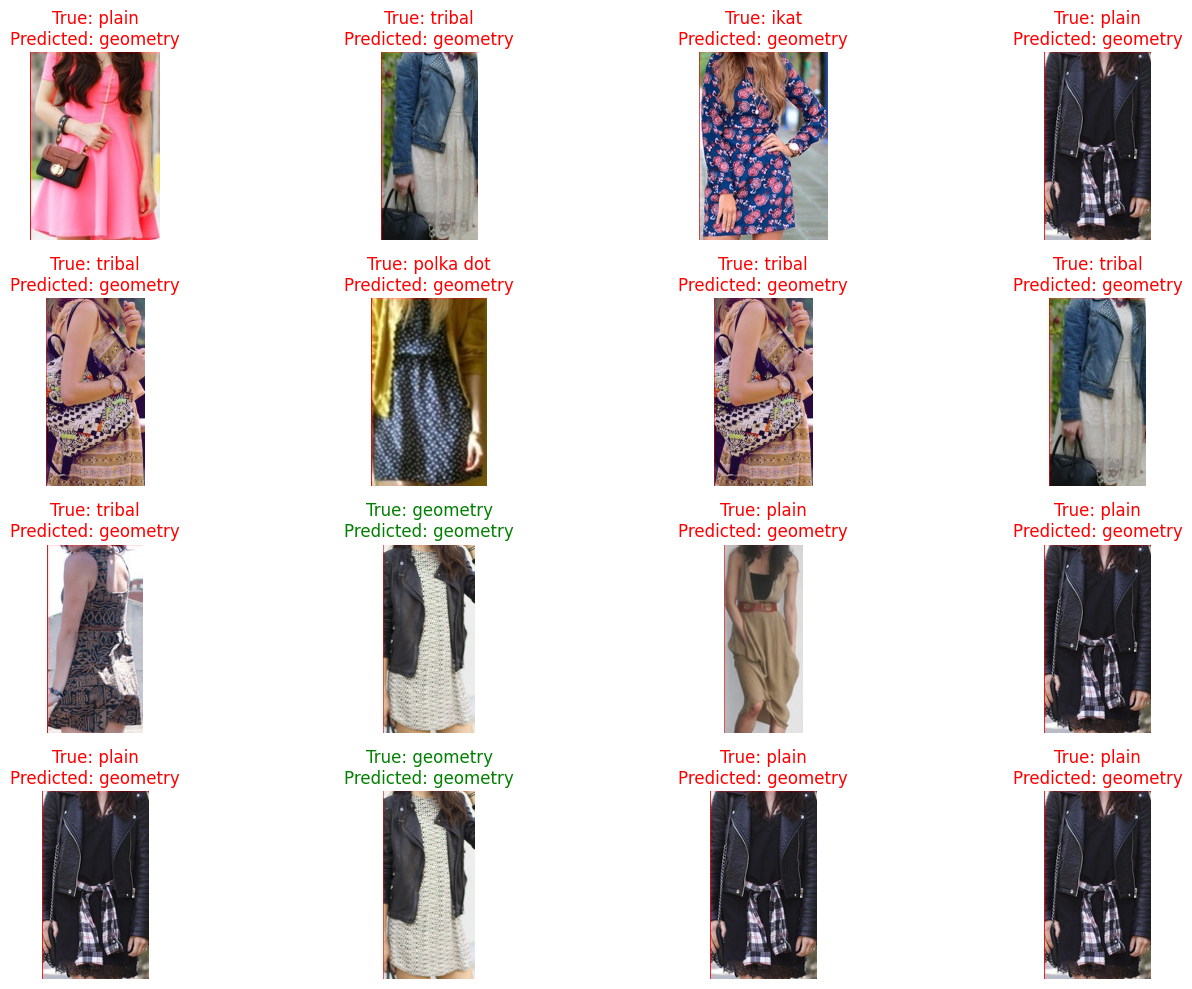

In [ ]:
from tensorflow.keras.preprocessing.image import load_img # Assuming load_img is defined or imported

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))
random_index = np.random.randint(0, len(test_gen), 16)

for i, ax in enumerate(axes.ravel()):
    img_path = test_df['path'].iloc[random_index[i]]

    ax.imshow(load_img(img_path))
    ax.axis('off')

    if test_df['label'].iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"

    ax.set_title(f"True: {test_df['label'].iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

plt.tight_layout()
plt.show()